In [69]:
import quasi_poisson

results = quasi_poisson.reg(np.array(y_train.tolist()), np.array(X_train.tolist()))

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [72]:
model = results['mle']
print(results['co-efficients'])

    estimate   std err     t_value       p_value           vif
0   7.687652  0.033786  227.539039  0.000000e+00  0.000000e+00
1   0.188525  0.020060    9.398092  0.000000e+00  4.125448e+00
2  -0.089258  0.047923   -1.862515  6.285410e-02  7.001416e+00
3  -0.056923  0.044431   -1.281157  2.004664e-01  1.236616e+01
4  -0.160081  0.026434   -6.055853  2.044527e-09           inf
5   0.073927  0.015717    4.703728  2.952495e-06           inf
6  -0.572329  0.069916   -8.185915  8.881784e-16           inf
7   0.086310  0.015607    5.530145  4.186413e-08           inf
8  -0.383224  0.044777   -8.558587  0.000000e+00           inf
9  -0.674932  0.088536   -7.623278  6.239453e-14           inf
10  0.110108  0.014608    7.537419  1.161293e-13           inf
11  0.156699  0.013185   11.884919  0.000000e+00           inf
12 -0.123361  0.024301   -5.076300  4.670852e-07           inf
13  0.063943  0.015604    4.097745  4.545939e-05           inf
14  0.206259  0.012578   16.398772  0.000000e+00       

In [1]:
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import jax.numpy as jnp
import arviz as az
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../../data/panel_data.csv')

data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['cases'] = data['cases'].astype(int)
data['t2m'] = np.log(data['t2m'] + 1)
data['tp'] = np.log(data['tp'] + 1)

data = data.sort_values(by=['state', 'time'])  # Ensure data is sorted
data['lag_cases'] = data.groupby('state')['cases'].shift(1)
data = data.dropna(subset=['lag_cases'])
data = pd.get_dummies(data, columns=['state', 'month'], drop_first=False)
states = [element.split('_')[1] for element in data.columns if element.startswith('state')]
data.head()

,time,t2m,tp,lai_hv,lai_lv,cases,deaths,year,lag_cases,state_BAHR EL GAZEL,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
33,2020-02-01,3.134018,0.001507,0.018410,0.666643,165,0.0,2020,259.0,True,...,False,False,False,False,False,False,False,False,False,False
56,2020-03-01,3.404349,0.000762,0.018419,0.672094,112,0.0,2020,165.0,True,...,True,False,False,False,False,False,False,False,False,False
79,2020-04-01,3.523705,0.000761,0.018420,0.674704,160,1.0,2020,112.0,True,...,False,True,False,False,False,False,False,False,False,False
102,2020-05-01,3.559914,0.006153,0.018420,0.676452,127,0.0,2020,160.0,True,...,False,False,True,False,False,False,False,False,False,False
125,2020-06-01,3.562694,0.057982,0.018422,0.686095,83,0.0,2020,127.0,True,...,False,False,False,True,False,False,False,False,False,False


In [3]:
data_test = data[data['time']>'2023-06-01']
X_test = jnp.array(data_test[['lag_cases','t2m', 'tp'] + [col for col in data_test.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
y_test = jnp.array(data_test['cases'].values.astype(int).tolist())

In [4]:
data_train = data[data['time']<='2023-06-01']
X_train = jnp.array(data_train[['lag_cases','t2m', 'tp'] + [col for col in data_train.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
y_train = jnp.array(data_train['cases'].values.astype(int).tolist())

In [5]:
X = jnp.concatenate((X_train, X_test), axis=0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train = X_scaled[:X_train.shape[0], :]
X_test = X_scaled[X_train.shape[0]:, :]

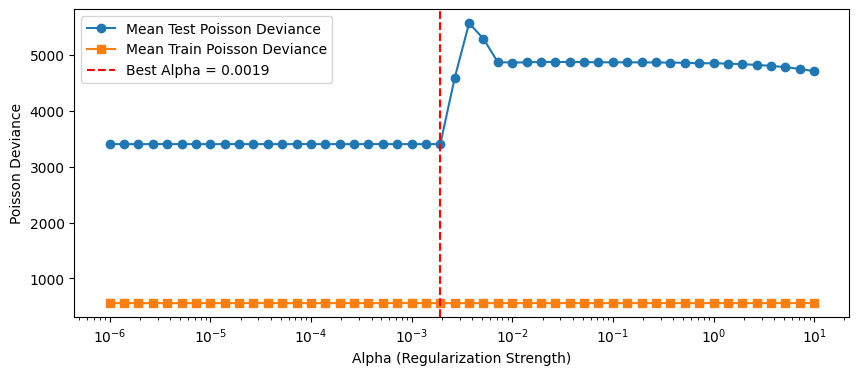

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import make_scorer, mean_poisson_deviance

# Define a range of alpha values
alpha_values = np.logspace(-6, 1, 50)

# Define the Poisson Regressor model
model = PoissonRegressor(max_iter=1000)

# Use GridSearchCV to test different alpha values
grid_search = GridSearchCV(
    model,
    param_grid={'alpha': alpha_values},
    scoring=make_scorer(mean_poisson_deviance, greater_is_better=False),  # Poisson deviance scoring
    cv=5,  # 5-fold cross-validation
    return_train_score=True  # Include training scores in the output
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Extract results
results = grid_search.cv_results_
mean_test_scores = -results['mean_test_score']  # Negative Poisson deviance is used for scoring
mean_train_scores = -results['mean_train_score']  # Training scores
alphas = results['param_alpha'].data.astype(float)

# Plot test and training performance
plt.figure(figsize=(10, 4))
plt.plot(alphas, mean_test_scores, label='Mean Test Poisson Deviance', marker='o')
plt.plot(alphas, mean_train_scores, label='Mean Train Poisson Deviance', marker='s')
plt.axvline(grid_search.best_params_['alpha'], color='r', linestyle='--', label=f"Best Alpha = {grid_search.best_params_['alpha']:.4f}")
plt.xscale('log')  # Use a log scale for alpha
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Poisson Deviance')
# plt.title('Grid Search Results: Choosing Alpha')
plt.legend()
# plt.grid(True)
plt.show()


In [7]:
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_poisson_deviance

class PoissonRegressionModel():
    def __init__(self, alpha, max_iter) -> None:
        self.alpha = alpha
        self.max_iter = max_iter
        self.model = PoissonRegressor(alpha=alpha, max_iter=max_iter, warm_start=True)
        self.coefficients = None
        
    def fit(self, X, y):
        self.model.fit(X, y)  # Fit model only once
        predictions = self.model.predict(X)
        loss = mean_poisson_deviance(y, predictions)  # Compute the Poisson deviance
        
        n_features = X.shape[1]
        idx_lag = 0
        idx_t2m = 1
        idx_tp = 2
        idx_state_start, idx_state_end = 3, 26
        idx_month_start, idx_month_end = 26, n_features
        
        self.coefficients = {
            "beta_lag": self.model.coef_[idx_lag],
            "beta_t2m": self.model.coef_[idx_t2m],
            "beta_tp": self.model.coef_[idx_tp],
            "beta_state": self.model.coef_[idx_state_start:idx_state_end],
            "beta_month": self.model.coef_[idx_month_start:idx_month_end],
            "intercept": self.model.intercept_
        }
        return self.coefficients, loss  # Return loss after fitting

    
    # def fit(self, X, y):
    #     # self.model.fit(X,y)
    #     losses = []
    #     for i in range(self.max_iter):  # Run for 100 iterations
    #         self.model.fit(X, y)  # Perform one step of optimization
    #         predictions = self.model.predict(X)  # Get predictions
    #         loss = mean_poisson_deviance(y, predictions)  # Compute Poisson loss
    #         losses.append(loss)
        
    #     n_features = X.shape[1]
    #     idx_lag = 0
    #     idx_t2m = 1
    #     idx_tp = 2
    #     idx_state_start, idx_state_end = 3, 26
    #     idx_month_start, idx_month_end = 26, n_features
        
    #     self.coefficients = {
    #         "beta_lag": self.model.coef_[idx_lag],
    #         "beta_t2m": self.model.coef_[idx_t2m],
    #         "beta_tp": self.model.coef_[idx_tp],
    #         "beta_state": self.model.coef_[idx_state_start:idx_state_end],
    #         "beta_month": self.model.coef_[idx_month_start:idx_month_end],
    #         "intercept": self.model.intercept_
    #     }
    #     return self.coefficients, losses
    
    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions

In [8]:
# model = PoissonRegressionModel(alpha=grid_search.best_params_['alpha'], max_iter=100)
model = PoissonRegressionModel(alpha=100.0, max_iter=500)
coefficients, losses = model.fit(X_train, y_train)

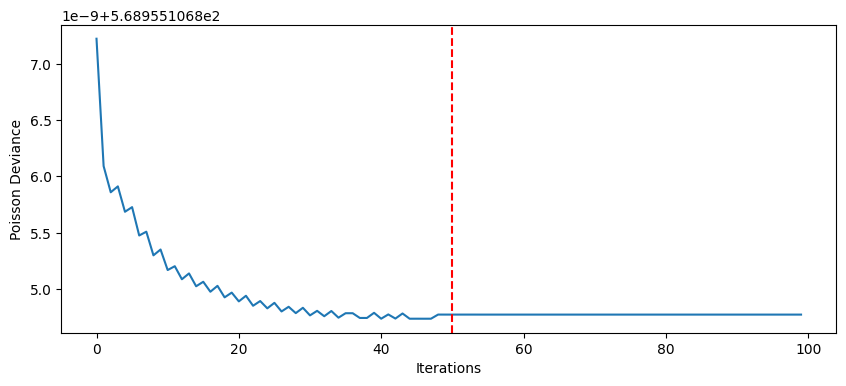

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(losses)
ax.set_xlabel("Iterations")
ax.set_ylabel("Poisson Deviance")
# plt.title("Convergence of Poisson Regressor")
ax.axvline(x=50, color='red', linestyle='--')
plt.show()

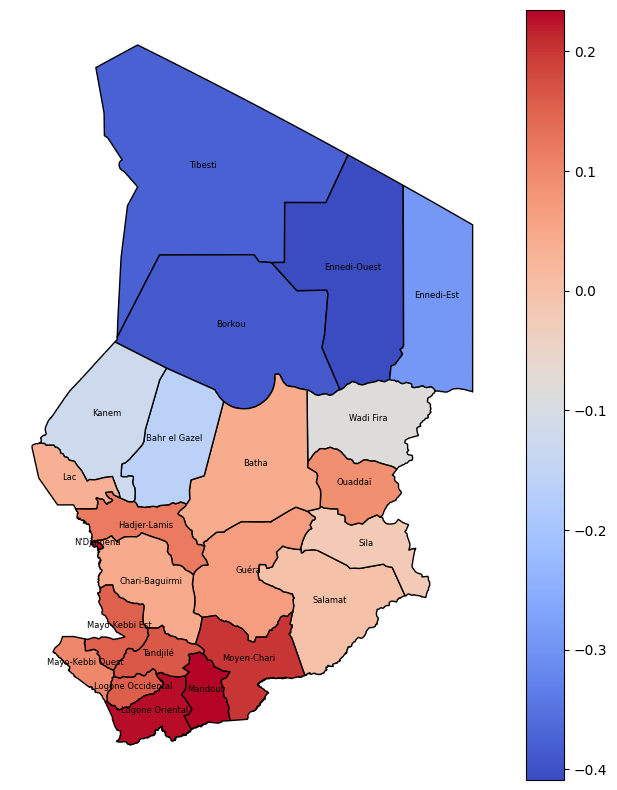

In [9]:
import cartopy.crs as ccrs
import geopandas as gpd

space_coefficients = coefficients['beta_state']
map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data.loc[21, 'shapeName'] = "N'Djamena"
shape_names = map_data['shapeName'].tolist()
shape_names.sort()
map_data['risk'] = [None]*23
for element in shape_names:
    map_data.loc[map_data['shapeName']==element, 'risk'] = space_coefficients[shape_names.index(element)]
map_data['risk'] = pd.to_numeric(map_data['risk'], errors='coerce')

map_data = map_data.to_crs(epsg=3857) 

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# ax = plt.axes(projection=ccrs.PlateCarree())
map_data.plot(edgecolor='black', column='risk', cmap='coolwarm', ax=ax, legend=True)
            #   legend_kwds={'label': "Malaria Risk", 'orientation': "vertical"})
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['shapeName']):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center')
plt.axis('off')

# plt.savefig('../../docs/risk-scores.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

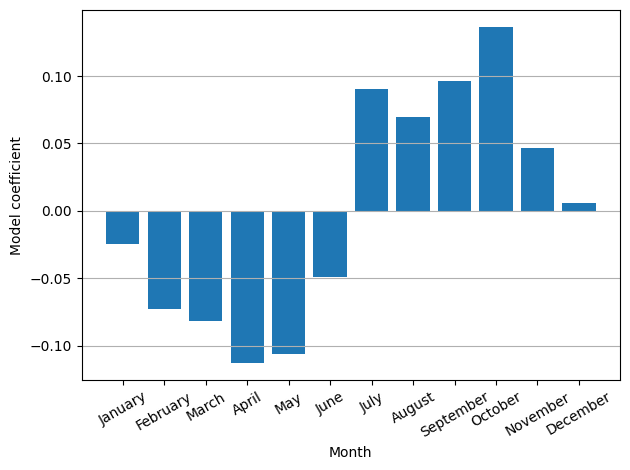

In [10]:
import matplotlib.pyplot as plt

# Corrected months list
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting the mean of 'beta_month' across the samples
plt.bar(months, coefficients['beta_month'])

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Model coefficient')
# plt.title('Mean beta_month Coefficients by Month')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=30)
plt.tight_layout()
plt.grid(axis='y')
# plt.savefig('../../docs/monthly-risk.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Pred vs. original

In [40]:
np.log(mean_post_pred)

array([140.42129518, 109.9316173 , 109.47517224,  71.01689667,
       102.48318433, 132.56371479, 165.89774846, 448.49992789,
       687.95077339, 693.79938278, 339.51691306, 197.07909419,
       205.65241349, 136.6824661 , 155.24083002, 141.11376334,
       175.90009676, 210.84676684, 294.42756597, 394.08245817,
       449.38245442, 352.61995264, 245.53432802, 140.4628545 ,
       131.35145318, 121.86147483, 113.01724957, 147.30446974,
       130.57373007, 137.92739752, 177.93122168, 370.63354924,
                inf,          inf,          inf, 422.17623888,
       247.66772726, 247.68842395, 217.82574231, 190.20617278,
       301.93928745, 353.15404587, 555.94105104,          inf,
                inf,          inf,          inf])

In [39]:
y[X[:,3+i]==1]

Array([ 462,  460,  286,  428,  563,  713, 1992, 3075, 3102, 1500,  856,
        895,  583,  667,  603,  760,  917, 1295, 1746, 1996, 1559, 1075,
        600,  559,  516,  476,  631,  555,  587,  768, 1640, 5161, 8936,
       4079, 1874, 1085, 1085,  950,  825, 1330, 1561, 2478, 3684, 5681,
       5281, 3310, 2460], dtype=int32)

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/matplotlib/ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


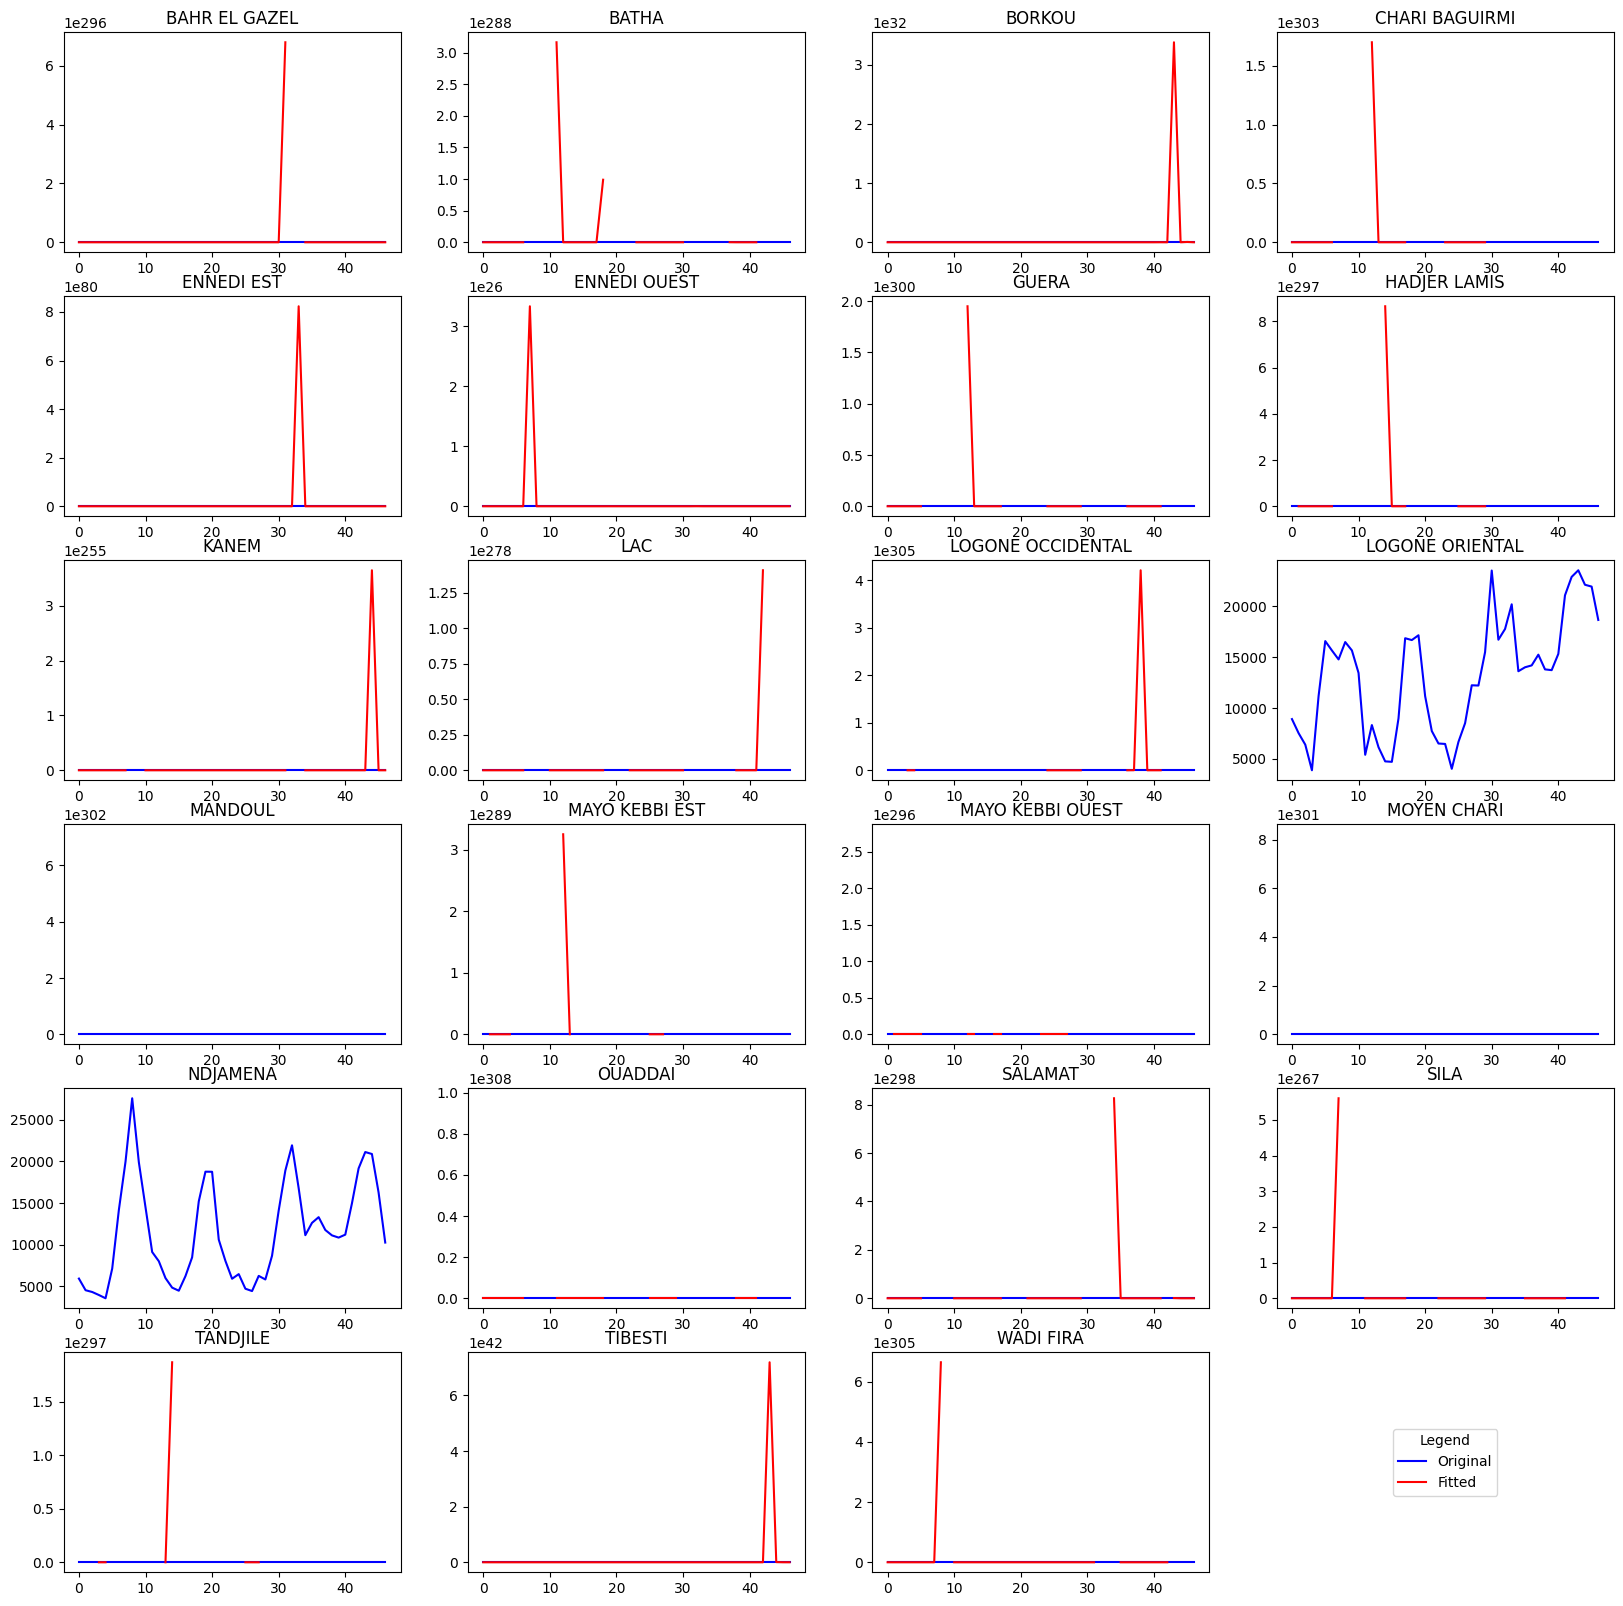

In [11]:
X = jnp.array(data[['lag_cases','t2m', 'tp'] + [col for col in data.columns if col.startswith('state_') or col.startswith('month_')]].values.tolist())
y = jnp.array(data['cases'].values.astype(int).tolist())

fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred = model.predict(X[X[:,3+i]==1])
    axes[idx,idy].plot(y[X[:,3+i]==1], label='Original', color='blue')
    axes[idx,idy].plot(mean_post_pred, label='Fitted', color='red')
    # axes[idx,idy].fill_between(xticks, inf_, sup_, color='black', alpha=0.5)
    axes[idx,idy].set_title(states[i])

axes[5, 3].clear()
axes[5, 3].axis('off')
handles, labels = axes[0, 0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[5, 3].transAxes, title='Legend')

# plt.savefig('../../docs/predictions.png', bbox_inches='tight', pad_inches=0.1)

## Residuals plot

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:573: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:573: RuntimeWarning: overflow encountered in cast
  return binary_op(*args)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/sklearn/_loss/link.py:177: RuntimeWarning: overflow encountered in exp
  return np.exp(raw_prediction, out=out)
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/jax/_src/numpy/a

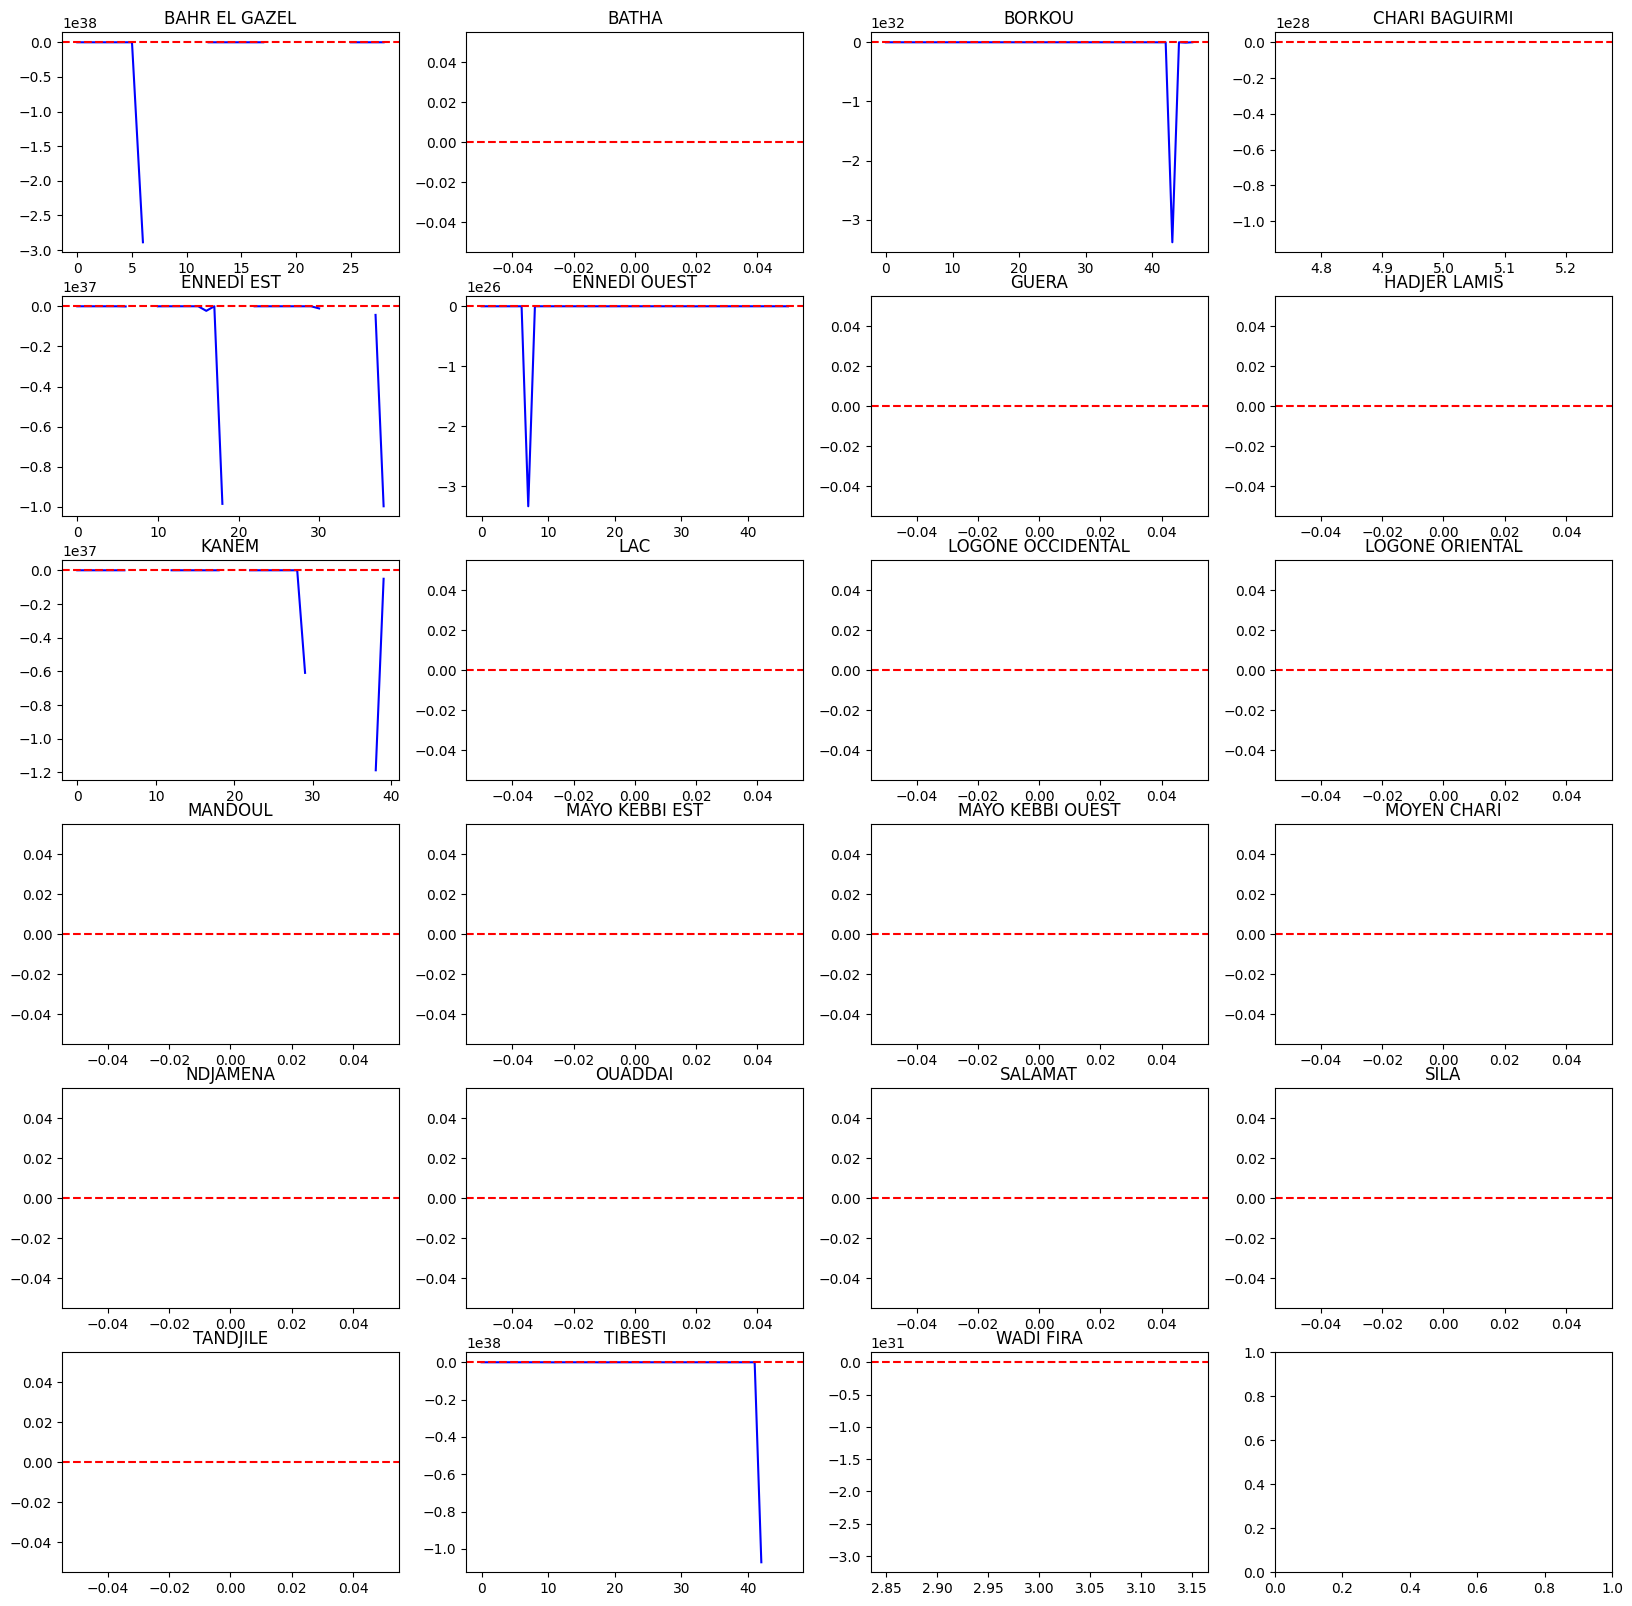

In [58]:
fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred = model.predict(X[X[:,3+i]==1])
    axes[idx,idy].plot(y[X[:,3+i]==1]-mean_post_pred, label='Original', color='blue')
    axes[idx,idy].axhline(0, color='red', linestyle='--')
    axes[idx,idy].set_title(states[i])

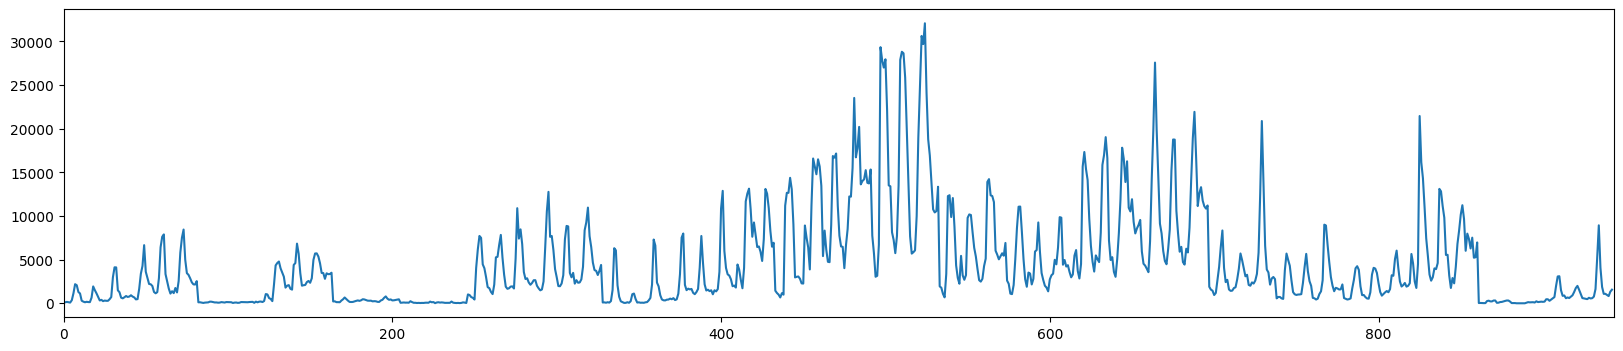

In [20]:
pred_mean = model.predict(X_train)

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(y_train-pred_mean)
# plt.savefig('../../docs/residual_train.png', bbox_inches='tight', pad_inches=0.1)
plt.xlim((0,len(pred_mean)))
plt.show()

## Evaluation metrics

In [135]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
samples_1 = mcmc.get_samples()
predictive = Predictive(panel_model, samples_1)
posterior_predictions = predictive(rng_key_, X=X_test)
post_obs = posterior_predictions['obs']

mean_post_pred = round(jnp.mean(post_obs, axis=0))
hpdi_post_pred = hpdi(post_obs, 0.9)

In [136]:
rmse = jnp.sqrt(((y_test - mean_post_pred)**2).mean())
mae = jnp.abs(y_test - mean_post_pred).mean()

ss_total = jnp.var(y_test)
ss_residual = jnp.mean((y_test - mean_post_pred.round()) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print('RMSE:', rmse)
print('MAE:', mae)
print(f'Bayesian R-squared: {r_squared}')

RMSE: 2434.3982
MAE: 1471.7174
Bayesian R-squared: 0.8699630498886108


In [59]:
y.mean()

Array(4779.8047, dtype=float32)

In [60]:
y.var()

Array(32227782., dtype=float32)